# Project Part 1 - Common Analysis
# Name: James Joko (jjoko)
## License
The cells pertaining to processing fire data in this notebook contains code developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the Creative Commons CC-BY license. The changes made include calculating distances of fires from Santa Fe.

For reproducibility, execute each cell from top to bottom.

# Setup
Importing packages to process fire data and geometry

In [160]:
import os, json, time
from pyproj import Transformer, Geod
from wildfire.Reader import Reader as WFReader
import geojson
from collections import defaultdict
import requests
import numpy as np

In [72]:
#
#    CONSTANTS
#

#
#    The 'Wildfire_short_sample.json' is an extraction from the full 'USGS_Wildland_Fire_Combined_Dataset.json'
#    dataset extracting some of the major wildfires in California. These were extracted by name, with possible names
#    coming from https://en.wikipedia.org/wiki/List_of_California_wildfires
#
#    The sample file includes data for 13 fires, mostly oriented around the uniqueness of the name. Naming conventions
#    for wildfires is really adhoc, which makes finding any named fire in the dataset a disambiguation mess. The point
#    of the sample is to provide something small to test with before committing to processing the much larger full dataset.
#
SAMPLE_DATA_FILENAME = "GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json"

# print out where we think we're going to find the sample data
print(f"{SAMPLE_DATA_FILENAME=}")

#
#    A dictionary of some city locations from the US west coast states.
#
CITY_LOCATIONS = {
    'anchorage' :     {'city'   : 'Anchorage',
                       'latlon' : [61.2176, -149.8997] },
    'ocean_shores' :  {'city'   : 'Ocean Shores',    
                       'latlon' : [47.0074, -124.1614] },
    'seaside' :       {'city'   : 'Seaside',
                       'latlon' : [45.9932, -123.9226] }, 
    'bend' :          {'city'   : 'Bend',
                       'latlon' : [44.0582, -121.3153] }, 
    'medford' :       {'city'   : 'Medford',
                       'latlon' : [42.3265, -122.8756] }, 
    'crescent_city' : {'city'   : 'Crescent City',
                       'latlon' : [41.7558, -124.2026] }, 
    'tomales' :       {'city'   : 'Tomales',
                       'latlon' : [38.2411, -122.9033] }, 
    'barstow' :       {'city'   : 'Barstow',
                       'latlon' : [34.8958, -117.0173] }, 
    'redding' :       {'city'   : 'Redding',
                       'latlon' : [40.5865, -122.3916] }, 
    'encinitas' :     {'city'   : 'Encinitas',
                       'latlon' : [33.0370, -117.2920] },
    'santa fe' :     {'city'   : 'Santa Fe',
                       'latlon' : [35.691544, -105.944183] } 
}

SAMPLE_DATA_FILENAME='GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json'


In [14]:
#
#    Open a file, load it with the geojson loader
#
print(f"Attempting to open '{SAMPLE_DATA_FILENAME}'")
geojson_file = open(SAMPLE_DATA_FILENAME,"r")
print(f"Using GeoJSON module to load sample file '{SAMPLE_DATA_FILENAME}'")
gj_data = geojson.load(geojson_file)
geojson_file.close()
#
#    Print the keys from the object
#
gj_keys = list(gj_data.keys())
print("The loaded JSON dictionary has the following keys:")
print(gj_keys)
print()
#
#    For all GeoJSON type things, the most important part of the file are the 'features'. 
#    In the case of the wildfire dataset, each feature is a polygon (ring) of points that define the bounary of a fire
#
count = sum([1 for feature in gj_data['features']])

print(f"Found {count} features in the variable 'gj_data' ")
#

Attempting to open 'GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json'
Using GeoJSON module to load sample file 'GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json'
The loaded JSON dictionary has the following keys:
['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features']

Found 135061 features in the variable 'gj_data' 


In [15]:
#
#    Get the first item in the list of features
#
SLOT = 0
gj_feature = gj_data['features'][SLOT]
#
#    Print everyting in this dictionary (i.e., gj_feature) - it's long
#
print(f"The wildfire feature from slot '{SLOT}' of the loaded gj_data['features']")
print(json.dumps(gj_feature, indent=4))


The wildfire feature from slot '0' of the loaded gj_data['features']
{
    "attributes": {
        "OBJECTID": 1,
        "USGS_Assigned_ID": 1,
        "Assigned_Fire_Type": "Wildfire",
        "Fire_Year": 1860,
        "Fire_Polygon_Tier": 1,
        "Fire_Attribute_Tiers": "1 (1)",
        "GIS_Acres": 3940.20708940724,
        "GIS_Hectares": 1594.5452365353703,
        "Source_Datasets": "Comb_National_NIFC_Interagency_Fire_Perimeter_History (1)",
        "Listed_Fire_Types": "Wildfire (1)",
        "Listed_Fire_Names": "Big Quilcene River (1)",
        "Listed_Fire_Codes": "No code provided (1)",
        "Listed_Fire_IDs": "",
        "Listed_Fire_IRWIN_IDs": "",
        "Listed_Fire_Dates": "Listed Other Fire Date(s): 2006-11-02 - NIFC DATE_CUR field (1)",
        "Listed_Fire_Causes": "",
        "Listed_Fire_Cause_Class": "Undetermined (1)",
        "Listed_Rx_Reported_Acres": null,
        "Listed_Map_Digitize_Methods": "Other (1)",
        "Listed_Notes": "",
        "Proce

In [16]:
#
#    Every feature has a 'geometry' which specifies geo coordinates that make up each geographic thing
#    In the case of the wildfire data, most wildfires are bounded shapes, circles, squares, etc. This is
#    represented by shapes called 'rings' in GeoJSON.
# 
# Get the geometry for the feature we pulled from the feature_list
gj_geometry = gj_feature['geometry']
# The largest shape (ring) is supposed to be item zero in the list of 'rings'
gj_bigest_ring = gj_geometry['rings'][0]

print(f"The largest ring of gj_feature['features'][{SLOT}]['rings'] consists of {len(gj_bigest_ring)} points.")

The largest ring of gj_feature['features'][0]['rings'] consists of 768 points.


In [17]:
#
#    This bit of code opens a new wildfire reader, gets the header information and prints it to the screen
#
print(f"Attempting to open '{SAMPLE_DATA_FILENAME}' with wildfire.Reader() object")
wfreader = WFReader(SAMPLE_DATA_FILENAME)
print()
#
#    Now print the header - it contains some useful information
#
header_dict = wfreader.header()
header_keys = list(header_dict.keys())
print("The header has the following keys:")
print(gj_keys)
print()
print("Header Dictionary")
print(json.dumps(header_dict,indent=4))

Attempting to open 'GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json' with wildfire.Reader() object

The header has the following keys:
['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features']

Header Dictionary
{
    "displayFieldName": "",
    "fieldAliases": {
        "OBJECTID": "OBJECTID",
        "USGS_Assigned_ID": "USGS Assigned ID",
        "Assigned_Fire_Type": "Assigned Fire Type",
        "Fire_Year": "Fire Year",
        "Fire_Polygon_Tier": "Fire Polygon Tier",
        "Fire_Attribute_Tiers": "Fire Attribute Tiers",
        "GIS_Acres": "GIS_Acres",
        "GIS_Hectares": "GIS_Hectares",
        "Source_Datasets": "Source Datasets",
        "Listed_Fire_Types": "Listed Fire Types",
        "Listed_Fire_Names": "Listed Fire Names",
        "Listed_Fire_Codes": "Listed Fire Codes",
        "Listed_Fire_IDs": "Listed Fire IDs",
        "Listed_Fire_IRWIN_IDs": "Listed Fire IRWIN IDs",
        "Listed_Fire_Dates": "Listed Fire Da

In [37]:
#
#    This sample code will load the whole sample file, or a small amount of the complete dataset.
#
# MAX_FEATURE_LOAD = 100
feature_list = list()
feature_count = 0
# A rewind() on the reader object makes sure we're at the start of the feature list
# This way, we can execute this cell multiple times and get the same result 
wfreader.rewind()
# Now, read through each of the features, saving them as dictionaries into a list
feature = wfreader.next()
while feature:
    feature_list.append(feature)
    feature_count += 1
    # if we're loading a lot of feat ures, print progress
    if (feature_count % 100) == 0:
        print(f"Loaded {feature_count} features")
    # loaded the max we're allowed then break
#     if feature_count >= MAX_FEATURE_LOAD:
#         break
    feature = wfreader.next()
#
#    Print the number of items (features) we think we loaded
print(f"Loaded a total of {feature_count} features")
#
#    Just a validation check - did all the items we loaded get into the list?
print(f"Variable 'feature_list' contains {len(feature_list)} features")

Loaded 100 features
Loaded 200 features
Loaded 300 features
Loaded 400 features
Loaded 500 features
Loaded 600 features
Loaded 700 features
Loaded 800 features
Loaded 900 features
Loaded 1000 features
Loaded 1100 features
Loaded 1200 features
Loaded 1300 features
Loaded 1400 features
Loaded 1500 features
Loaded 1600 features
Loaded 1700 features
Loaded 1800 features
Loaded 1900 features
Loaded 2000 features
Loaded 2100 features
Loaded 2200 features
Loaded 2300 features
Loaded 2400 features
Loaded 2500 features
Loaded 2600 features
Loaded 2700 features
Loaded 2800 features
Loaded 2900 features
Loaded 3000 features
Loaded 3100 features
Loaded 3200 features
Loaded 3300 features
Loaded 3400 features
Loaded 3500 features
Loaded 3600 features
Loaded 3700 features
Loaded 3800 features
Loaded 3900 features
Loaded 4000 features
Loaded 4100 features
Loaded 4200 features
Loaded 4300 features
Loaded 4400 features
Loaded 4500 features
Loaded 4600 features
Loaded 4700 features
Loaded 4800 features
L

Loaded 37900 features
Loaded 38000 features
Loaded 38100 features
Loaded 38200 features
Loaded 38300 features
Loaded 38400 features
Loaded 38500 features
Loaded 38600 features
Loaded 38700 features
Loaded 38800 features
Loaded 38900 features
Loaded 39000 features
Loaded 39100 features
Loaded 39200 features
Loaded 39300 features
Loaded 39400 features
Loaded 39500 features
Loaded 39600 features
Loaded 39700 features
Loaded 39800 features
Loaded 39900 features
Loaded 40000 features
Loaded 40100 features
Loaded 40200 features
Loaded 40300 features
Loaded 40400 features
Loaded 40500 features
Loaded 40600 features
Loaded 40700 features
Loaded 40800 features
Loaded 40900 features
Loaded 41000 features
Loaded 41100 features
Loaded 41200 features
Loaded 41300 features
Loaded 41400 features
Loaded 41500 features
Loaded 41600 features
Loaded 41700 features
Loaded 41800 features
Loaded 41900 features
Loaded 42000 features
Loaded 42100 features
Loaded 42200 features
Loaded 42300 features
Loaded 424

Loaded 75200 features
Loaded 75300 features
Loaded 75400 features
Loaded 75500 features
Loaded 75600 features
Loaded 75700 features
Loaded 75800 features
Loaded 75900 features
Loaded 76000 features
Loaded 76100 features
Loaded 76200 features
Loaded 76300 features
Loaded 76400 features
Loaded 76500 features
Loaded 76600 features
Loaded 76700 features
Loaded 76800 features
Loaded 76900 features
Loaded 77000 features
Loaded 77100 features
Loaded 77200 features
Loaded 77300 features
Loaded 77400 features
Loaded 77500 features
Loaded 77600 features
Loaded 77700 features
Loaded 77800 features
Loaded 77900 features
Loaded 78000 features
Loaded 78100 features
Loaded 78200 features
Loaded 78300 features
Loaded 78400 features
Loaded 78500 features
Loaded 78600 features
Loaded 78700 features
Loaded 78800 features
Loaded 78900 features
Loaded 79000 features
Loaded 79100 features
Loaded 79200 features
Loaded 79300 features
Loaded 79400 features
Loaded 79500 features
Loaded 79600 features
Loaded 797

Loaded 111900 features
Loaded 112000 features
Loaded 112100 features
Loaded 112200 features
Loaded 112300 features
Loaded 112400 features
Loaded 112500 features
Loaded 112600 features
Loaded 112700 features
Loaded 112800 features
Loaded 112900 features
Loaded 113000 features
Loaded 113100 features
Loaded 113200 features
Loaded 113300 features
Loaded 113400 features
Loaded 113500 features
Loaded 113600 features
Loaded 113700 features
Loaded 113800 features
Loaded 113900 features
Loaded 114000 features
Loaded 114100 features
Loaded 114200 features
Loaded 114300 features
Loaded 114400 features
Loaded 114500 features
Loaded 114600 features
Loaded 114700 features
Loaded 114800 features
Loaded 114900 features
Loaded 115000 features
Loaded 115100 features
Loaded 115200 features
Loaded 115300 features
Loaded 115400 features
Loaded 115500 features
Loaded 115600 features
Loaded 115700 features
Loaded 115800 features
Loaded 115900 features
Loaded 116000 features
Loaded 116100 features
Loaded 1162

In [19]:
#
#    The 'feature_list' variable was created when we read the sample file in a code cell above
#    Now, we're just going to look at one single feature - see what is in there
#
SLOT = 0
wf_feature = feature_list[SLOT]

# Print everyting in this dictionary (i.e., wf_feature) - it's long
print(f"The wildfire feature from slot '{SLOT}' of the loaded 'feature_list'")
print(json.dumps(wf_feature, indent=4))

The wildfire feature from slot '0' of the loaded 'feature_list'
{
    "attributes": {
        "OBJECTID": 1,
        "USGS_Assigned_ID": 1,
        "Assigned_Fire_Type": "Wildfire",
        "Fire_Year": 1860,
        "Fire_Polygon_Tier": 1,
        "Fire_Attribute_Tiers": "1 (1)",
        "GIS_Acres": 3940.20708940724,
        "GIS_Hectares": 1594.5452365353703,
        "Source_Datasets": "Comb_National_NIFC_Interagency_Fire_Perimeter_History (1)",
        "Listed_Fire_Types": "Wildfire (1)",
        "Listed_Fire_Names": "Big Quilcene River (1)",
        "Listed_Fire_Codes": "No code provided (1)",
        "Listed_Fire_IDs": "",
        "Listed_Fire_IRWIN_IDs": "",
        "Listed_Fire_Dates": "Listed Other Fire Date(s): 2006-11-02 - NIFC DATE_CUR field (1)",
        "Listed_Fire_Causes": "",
        "Listed_Fire_Cause_Class": "Undetermined (1)",
        "Listed_Rx_Reported_Acres": null,
        "Listed_Map_Digitize_Methods": "Other (1)",
        "Listed_Notes": "",
        "Processing

In [20]:
#
#    Every feature has a 'geometry' which specifies geo coordinates that make up each geographic thing
#    In the case of the wildfire data, most wildfires are bounded shapes, circles, squares, etc. This is
#    represented by shapes called 'rings' in GeoJSON.
# 
# Get the geometry for the feature we pulled from the feature_list
wf_geometry = wf_feature['geometry']
# The largest shape (ring) is supposed to be item zero in the list of 'rings'
wf_bigest_ring = wf_geometry['rings'][0]

print(f"The largest ring of wf_feature['features'][{SLOT}]['rings'] consists of {len(wf_bigest_ring)} points.")

The largest ring of wf_feature['features'][0]['rings'] consists of 768 points.


In [73]:
#
#    First create a geodesic model that will be used for the calculations. There are a number of
#    different models of the earth. The WSG84 is one that is commonly used and relatively up-to-date
#
#geodcalc = Geod(ellps='clrk66')       # Use Clarke 1866 ellipsoid representation of the earth
geodcalc = Geod(ellps='WGS84')         # Use WGS84 ellipsoid representation of the earth

#    Two constants for accessing the 'latlon' array in our CITY_LOCATIONS constant dict
LAT = 0
LON = 1
#    Get a city from our CITY_LOCATIONS constant as our starting position
start_at = CITY_LOCATIONS["santa fe"]

#    Loop through all of the cities to calculate the distance from the starting position
for city_key in CITY_LOCATIONS.keys():
    #    City destination
    destination = CITY_LOCATIONS[city_key]
    #    Note that the 'inv()' function wants coordinates in Longitude,Latitude order by default
    #    inv() also allows lat and lon parameters to be vectors/arrays - in which case the results would be vector/arrarys
    distance = geodcalc.inv(start_at['latlon'][LON],start_at['latlon'][LAT],destination['latlon'][LON],destination['latlon'][LAT])
    #    The 'distance' result variable is a tuple/list with the first two items reflecting forward/backward azimuths
    #    and the third item representing the distance in meters. 
    d_meters = distance[2]
    d_miles = d_meters * 0.00062137 # constant to convert meters to miles
    #    BTW, this isn't actually a 'straight' line because the whole reason for using pyproj is to calculate
    #    these distance measures over the surfase of a sphere/ellipsoid. We set up which ellipsoid to use when we
    #    defined the 'geodcalc' object near the top of this cell
    print(f"Straight line distance from {start_at['city']} to {destination['city']} is {d_meters} meters or {d_miles:5.2f} miles")

Straight line distance from Santa Fe to Anchorage is 4181707.6212741355 meters or 2598.39 miles
Straight line distance from Santa Fe to Ocean Shores is 1967230.3935838337 meters or 1222.38 miles
Straight line distance from Santa Fe to Seaside is 1891936.7174170867 meters or 1175.59 miles
Straight line distance from Santa Fe to Bend is 1605734.0281163587 meters or 997.75 miles
Straight line distance from Santa Fe to Medford is 1637029.446057348 meters or 1017.20 miles
Straight line distance from Santa Fe to Crescent City is 1720170.0634686768 meters or 1068.86 miles
Straight line distance from Santa Fe to Tomales is 1534199.646312018 meters or 953.31 miles
Straight line distance from Santa Fe to Barstow is 1010538.8051387526 meters or 627.92 miles
Straight line distance from Santa Fe to Redding is 1537911.1482982032 meters or 955.61 miles
Straight line distance from Santa Fe to Encinitas is 1083866.7970602836 meters or 673.48 miles
Straight line distance from Santa Fe to Santa Fe is 0.0

In [30]:
#
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

In [31]:
#
#   Convert one ring from the default to EPSG
#
#   There are two options here - depending upon whether you loaded data useing GeoJSON or the wildfire.Reader
#
#ring_in_epsg4326 = convert_ring_to_epsg4326(gj_bigest_ring)
#
ring_in_epsg4326 = convert_ring_to_epsg4326(wf_bigest_ring)
#
print(f"Ring consists of {len(ring_in_epsg4326)} points.")
#
#    If you want to print them out you can see what they look like converted.
#print(ring_in_epsg4326)
#for point in ring_in_epsg4326:
#    print(f"{point[0]},{point[1]}")


Ring consists of 768 points.


In [35]:
#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns a list containing the shortest distance to the perimeter and the point where that is
#
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point

For every fire in the dataset, I store the metadata of all fires that occur between 1963 and the present and whose closest point is within 1250 miles of Santa Fe.

In [74]:
#    Get a city from our CITY_LOCATIONS constant as our starting position
place = CITY_LOCATIONS["santa fe"]

in_range = []
count = 0

for wf_feature in feature_list:
    count += 1
    # if we're loading a lot of feat ures, print progress
    if (count % 5000) == 0:
        print(f"Finished {count} features, in_range len: {len(in_range)}")
    #print(f"{place['city']}")
    wf_year = wf_feature['attributes']['Fire_Year']
    if wf_year < 1963 or wf_year > 2023:
        continue
    wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
    wf_size = wf_feature['attributes']['GIS_Acres']
    wf_type = wf_feature['attributes']['Assigned_Fire_Type']
    try:
        ring_data = wf_feature['geometry']['rings'][0]
    except KeyError:
        continue
    #
    #     Compute using the shortest distance to any point on the perimeter
    #
    distance = shortest_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)
    if distance[0] > 1250:
        continue
#     print(f"The closest distance of fire '{wf_name}' ({wf_size:1.2f} acres) from {wf_year} was {distance[0]:1.2f} miles to {place['city']}")
#     print(f"\tThe cloest perimiter point lat,lon {distance[1][0]},{distance[1][1]}")
    wf_feature['attributes']['Distance_to_SF'] = distance[0]
    in_range.append(wf_feature)

Finished 5000 features, in_range len: 0
Finished 10000 features, in_range len: 0
Finished 15000 features, in_range len: 689
Finished 20000 features, in_range len: 5190
Finished 25000 features, in_range len: 9575
Finished 30000 features, in_range len: 13871
Finished 35000 features, in_range len: 17793
Finished 40000 features, in_range len: 21965
Finished 45000 features, in_range len: 26095
Finished 50000 features, in_range len: 30338
Finished 55000 features, in_range len: 34757
Finished 60000 features, in_range len: 38999
Finished 65000 features, in_range len: 43384
Finished 70000 features, in_range len: 47575
Finished 75000 features, in_range len: 51908
Finished 80000 features, in_range len: 55688
Finished 85000 features, in_range len: 58249
Finished 90000 features, in_range len: 61329
Finished 95000 features, in_range len: 65925
Finished 100000 features, in_range len: 69965
Finished 105000 features, in_range len: 72937
Finished 110000 features, in_range len: 77382
Finished 115000 feat

I then write the metadata of the previously mentioned fires to disk in case I need it

In [82]:
with open("Intermediate Data/santa_fe_fires.json", 'w') as json_file:
    json.dump(in_range, json_file)

# Step 1: Create fire smoke estimates
To create my smoke estimate, I considered that a large fire that burns a lot of acres would produce more smoke than a small fire. A fire farther away from my city would put less smoke in my city than a fire close by. Secondly, [a prescribed fire will produce significantly less smoke than a wildfire](https://scholarworks.sjsu.edu/cgi/viewcontent.cgi?referer=&httpsredir=1&article=4554&context=etd_theses#:~:text=Wildfires%20can%20and%20often%20do,from%20the%20local%20urban%20areas.). Therefore, I scaled the smoke estimate down by a third when the source was a prescribed fire. Thirdly, I added a factor of 250 in the denominator to align it closer with AQI. Lastly, I took the sum of this calculation on all fires in a year for my yearly smoke estimate. I did not want to take an average because a year with a large number of fires would have smoke from all the fires cumulatively added together.

In [195]:
from collections import defaultdict
smoke_estimate_by_year = defaultdict(float)
for feature in in_range:
    wf_year = feature['attributes']['Fire_Year']
    wf_size = feature['attributes']['GIS_Acres']
    wf_type = feature['attributes']['Assigned_Fire_Type']
    prescribed = ["Prescribed Fire", "Unknown - Likely Prescribed Fire"]
    wf_distance_to_sf = feature['attributes']['Distance_to_SF']
    if wf_type in prescribed:
        smoke_estimate_by_year[wf_year] += (wf_size*(1/3))/(wf_distance_to_sf * 250)
    else:
        smoke_estimate_by_year[wf_year] += wf_size/(wf_distance_to_sf * 250)

# Step 1.1: Get AQI for Santa Fe
## License
The cells pertaining to processing fire data in this notebook contains code developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the Creative Commons CC-BY license. The changes made include calculating distances of fires form Santa Fe.

Yearly AQI is calculated by the following steps:
- A daily summary of gaseous and particulate AQI is pulled from the EPA's API
- The AQI for a given day is the maximum reading of gaseous or particulate throughout that day.
- The daily AQI is calcuated for every day in an entire year's fire season, which is from May 1st to October 31st
- The average AQI of all days in a year's fire season is the estimated yearly AQI

In [104]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}



In [105]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")
    
    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [108]:
#
#    A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through
#    This code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request
#
# print("Requesting SIGNUP ...")
# response = request_signup("jjoko@uw.edu")
# print(json.dumps(response,indent=4))
#

Requesting SIGNUP ...
{
    "Header": [
        {
            "status": "Success",
            "request_time": "2023-11-08T20:22:18-05:00",
            "url": "https://aqs.epa.gov/data/api/signup?email=jjoko@uw.edu"
        }
    ],
    "Data": [
        "You should receive a registration confirmation email with a link for confirming your email shortly."
    ]
}


In [110]:
#
#   Once we have the signup email, we can define two constants
#   USERNAME - This should be the email address you sent the EPA asking for access to the API during sign-up
#   APIKEY   - This should be the authorization key they sent you
#
#   In this case I don't want to distribute my keys with the source of the notebook, so I wrote a key manager object that
#   helps track all of my API keys - a username and domain name retrieves the key. The key manager hides the keys on disk
#   separate from the code. Often you see code that assumes you have stored your API key as an OS environment variable.
#
USERNAME = "jjoko@uw.edu"
APIKEY = "greyram57"

In [111]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [112]:
#
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "AIRNOW MAPS",
        "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
    },
    {
        "code": "ALL",
        "value_represented": "Select all Parameters Available"
    },
    {
        "code": "AQI POLLUTANTS",
        "value_represented": "Pollutants that have an AQI Defined"
    },
    {
        "code": "CORE_HAPS",
        "value_represented": "Urban Air Toxic Pollutants"
    },
    {
        "code": "CRITERIA",
        "value_represented": "Criteria Pollutants"
    },
    {
        "code": "CSN DART",
        "value_represented": "List of CSN speciation parameters to populate the STI DART tool"
    },
    {
        "code": "FORECAST",
        "value_represented": "Parameters routinely extracted by AirNow (STI)"
    },
    {
        "code": "HAPS",
        "value_represented": "Hazardous Air Pollutants"
    },
    {
        "code": "IMPROVE CARBON",
        "value_represented": "IMPROVE Carbon Parameters"
    }

In [113]:
#
#   Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
#   The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
#   We'll use that to make another list request.
#
AQI_PARAM_CLASS = "AQI POLLUTANTS"

In [114]:
#
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


In [115]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#   
#

In [119]:
#
#   We'll use these two city locations in the examples below.
#
CITY_LOCATIONS = {
    'seaside' :       {'city'   : 'Seaside',
                       'county' : 'Clatsop',
                       'state'  : 'Oregon',
                       'fips'   : '41007',
                       'latlon' : [45.9932, -123.9226] }, 
    'bend' :          {'city'   : 'Bend',
                       'county' : 'Deschutes',
                       'state'  : 'Oregon',
                       'fips'   : '41017',
                       'latlon' : [44.0582, -121.3153] },
    'santa fe' :      {'city'   : 'Santa Fe city',
                       'county' : 'Santa Fe County',
                       'state'  : 'New Mexico',
                       'fips'   : '35049',
                       'latlon' : [35.691544, -105.944183] }
}


In [120]:
#
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['santa fe']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['santa fe']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "0001",
        "value_represented": null
    },
    {
        "code": "0002",
        "value_represented": null
    },
    {
        "code": "0003",
        "value_represented": null
    },
    {
        "code": "0004",
        "value_represented": null
    },
    {
        "code": "0005",
        "value_represented": null
    },
    {
        "code": "0012",
        "value_represented": null
    },
    {
        "code": "0018",
        "value_represented": null
    },
    {
        "code": "0019",
        "value_represented": null
    },
    {
        "code": "0020",
        "value_represented": null
    },
    {
        "code": "0021",
        "value_represented": null
    },
    {
        "code": "9002",
        "value_represented": "LANL IS APPROXIMATELY 15.5 MILES W OF THE PUEBLO OF POJOAQUE."
    }
]


In [121]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [124]:
#
#    This is a list of field names - data - that will be extracted from each record
#
EXTRACTION_FIELDS = ['sample_duration','observation_count','arithmetic_mean','aqi']

#
#    The function creates a summary record
def extract_summary_from_response(r=None, fields=EXTRACTION_FIELDS):
    ## the result will be structured around monitoring site, parameter, and then date
    result = dict()
    data = r["Data"]
    for record in data:
        # make sure the record is set up
        site = record['site_number']
        param = record['parameter_code']
        #date = record['date_local']    # this version keeps the respnse value YYYY-
        date = record['date_local'].replace('-','') # this puts it in YYYYMMDD format
        if site not in result:
            result[site] = dict()
            result[site]['local_site_name'] = record['local_site_name']
            result[site]['site_address'] = record['site_address']
            result[site]['state'] = record['state']
            result[site]['county'] = record['county']
            result[site]['city'] = record['city']
            result[site]['pollutant_type'] = dict()
        if param not in result[site]['pollutant_type']:
            result[site]['pollutant_type'][param] = dict()
            result[site]['pollutant_type'][param]['parameter_name'] = record['parameter']
            result[site]['pollutant_type'][param]['units_of_measure'] = record['units_of_measure']
            result[site]['pollutant_type'][param]['method'] = record['method']
            result[site]['pollutant_type'][param]['data'] = dict()
        if date not in result[site]['pollutant_type'][param]['data']:
            result[site]['pollutant_type'][param]['data'][date] = list()
        
        # now extract the specified fields
        extract = dict()
        for k in fields:
            if str(k) in record:
                extract[str(k)] = record[k]
            else:
                # this makes sure we always have the requested fields, even if
                # we have a missing value for a given day/month
                extract[str(k)] = None
        
        # add this extraction to the list for the day
        result[site]['pollutant_type'][param]['data'][date].append(extract)
    
    return result


For every year from 1963 to the present, I obtain the daily summary of gaseous and particulate aqi and perform the procedure written in the start of this section.

In [164]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['santa fe']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['santa fe']['fips'][2:]

yearly_aqi = {}
for year in range(1963, 2024):
    request_data['param'] = AQI_PARAMS_GASEOUS
    gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=str(year)+"0501", end_date=str(year)+"1031")
    print("Response for the gaseous pollutants ...")

    request_data['param'] = AQI_PARAMS_PARTICULATES
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=str(year)+"0501", end_date=str(year)+"1031")
    print("Response for the particulate pollutants ...")

    extract_gaseous = extract_summary_from_response(gaseous_aqi)
    # print("Summary of gaseous extraction ...")
    # print(json.dumps(extract_gaseous,indent=4))

    extract_particulate = extract_summary_from_response(particulate_aqi)
    # print("Summary of particulate extraction ...")
    # print(json.dumps(extract_particulate,indent=4))

    daily_aqi = defaultdict(int)

    for monitor in extract_gaseous.values():
        for pollutant in monitor["pollutant_type"].values():
            for date, data in pollutant["data"].items():
                if not data:
                    continue
                dat = max([obs["aqi"] for obs in data if obs["aqi"] != None], default=0)
                daily_aqi[date] = max(daily_aqi[date], dat)

    for monitor in extract_particulate.values():
        for pollutant in monitor["pollutant_type"].values():
            for date, data in pollutant["data"].items():
                if not data:
                    continue
                dat = max([obs["aqi"] for obs in data if obs["aqi"] != None], default=0)
                daily_aqi[date] = max(daily_aqi[date], dat)
    
    if len(daily_aqi) == 0:
        continue
    yearly_aqi[year] = np.mean(list(daily_aqi.values()))

Response for the gaseous pollutants ...
Response for the particulate pollutants ...
Response for the gaseous pollutants ...
Response for the particulate pollutants ...
Response for the gaseous pollutants ...
Response for the particulate pollutants ...
Response for the gaseous pollutants ...
Response for the particulate pollutants ...
Response for the gaseous pollutants ...
Response for the particulate pollutants ...
Response for the gaseous pollutants ...
Response for the particulate pollutants ...
Response for the gaseous pollutants ...
Response for the particulate pollutants ...
Response for the gaseous pollutants ...
Response for the particulate pollutants ...
Response for the gaseous pollutants ...
Response for the particulate pollutants ...
Response for the gaseous pollutants ...
Response for the particulate pollutants ...
Response for the gaseous pollutants ...
Response for the particulate pollutants ...
Response for the gaseous pollutants ...
Response for the particulate polluta

In [167]:
with open("Intermediate Data/santa_fe_yearly_aqi.json", 'w') as json_file:
    json.dump(yearly_aqi, json_file)

# Predictive Model

# Visualizations

In [83]:
import matplotlib.pyplot as plt

The first visualization is to produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance. I get the distances of all fires in range and make a histogram on them.

In [86]:
distances = [feature['attributes']['Distance_to_SF'] for feature in in_range]
year_buckets = range(0, 1250, 50)

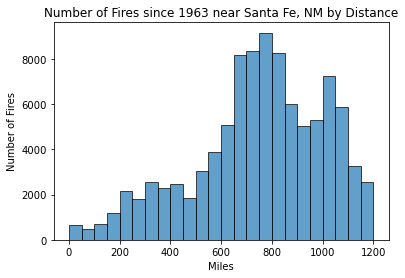

In [92]:
plt.hist(distances, bins = year_buckets, edgecolor='black', alpha=0.7)
plt.xlabel('Miles')
plt.ylabel('Number of Fires')
plt.title('Number of Fires since 1963 near Santa Fe, NM by Distance')
plt.show()

The second histogram is to produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city. I create a dictionary to keep track of the total acres burned using year as the key and 

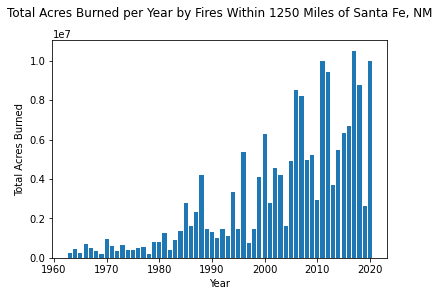

In [94]:
from collections import defaultdict
acreage_by_year = defaultdict(float)
for feature in in_range:
    acreage_by_year[feature['attributes']['Fire_Year']] += feature['attributes']['GIS_Acres']
    
plt.bar(list(acreage_by_year.keys()), list(acreage_by_year.values()))
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.title('Total Acres Burned per Year by Fires Within 1250 Miles of Santa Fe, NM', y=1.08)
plt.show()

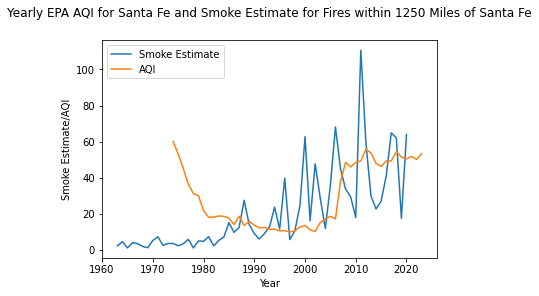

In [198]:
plt.plot(list(smoke_estimate_by_year.keys()), list(smoke_estimate_by_year.values()), label="Smoke Estimate")
plt.plot(list(yearly_aqi.keys()), list(yearly_aqi.values()), label = "AQI")
plt.xlabel('Year')
plt.ylabel('Smoke Estimate/AQI')
plt.title('Yearly EPA AQI for Santa Fe and Smoke Estimate for Fires within 1250 Miles of Santa Fe', y=1.08)
plt.legend()
plt.show()